# Process ATL03 with custom ATL08 30m rebinning via Sliderule 

Paul Montesano, PhD

## Import libaries
Importing libs, in particular the sliderule.  This is installed onto the workspace with a conda call such as:

`conda install -c conda-forge sliderule`

After the package is installed in the workspace, it can be imported as normal

In [42]:
conda update -c conda-forge sliderule

done

Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import pandas as pd
import logging 
import sliderule
from sliderule import icesat2

In [2]:
sliderule.__version__

'4.6.3'

In [3]:
sliderule.init()

True

In [4]:
ICESAT2_BOREAL_REPO_PATH = '/projects/code/icesat2_boreal'               #'/projects/icesat2_boreal' # /projects/Developer/icesat2_boreal/lib
ICESAT2_BOREAL_LIB_PATH = ICESAT2_BOREAL_REPO_PATH + '/lib'
import sys, os
sys.path.append(ICESAT2_BOREAL_LIB_PATH)
import CovariateUtils
import maplib_folium
import mosaiclib
from mosaiclib import *
from pathlib import Path
import glob

## Initialize server to process with SlidRule

In [5]:
import process_atl08_boreal
import time

NASA MAAP


In [6]:
import importlib
importlib.reload(process_atl08_boreal)

<module 'process_atl08_boreal' from '/projects/code/icesat2_boreal/lib/process_atl08_boreal.py'>

In [7]:
def sliderule_init(PUBLIC=False):
    logging.basicConfig(level=logging.INFO)
    if PUBLIC:
        sliderule.init("slideruleearth.io", verbose=True, loglevel=logging.INFO, 
                     organization='sliderule', #'utexas'
                     desired_nodes=5)
    else:
        # This version has the update that fixes an insidious flag bug (2/22/2024)
        sliderule.init("slideruleearth.io", verbose=True, loglevel=logging.INFO, 
                     organization='utexas', 
                     desired_nodes=10, time_to_live=720)

In [8]:
sliderule.init()

True

In [9]:
sliderule_init(PUBLIC=True)

Setting URL to slideruleearth.io
INFO:sliderule.sliderule:Setting URL to slideruleearth.io
Login status to slideruleearth.io/sliderule: failure
INFO:sliderule.sliderule:Login status to slideruleearth.io/sliderule: failure
400 Client Error: Bad Request for url: https://ps.slideruleearth.io/api/org_num_nodes/sliderule/
INFO:sliderule.sliderule:400 Client Error: Bad Request for url: https://ps.slideruleearth.io/api/org_num_nodes/sliderule/
Provisioning system status request returned error => No token is provided in the header or the header is missing
INFO:sliderule.sliderule:Provisioning system status request returned error => No token is provided in the header or the header is missing
400 Client Error: Bad Request for url: https://ps.slideruleearth.io/api/desired_org_num_nodes_ttl/sliderule/5/60/
INFO:sliderule.sliderule:400 Client Error: Bad Request for url: https://ps.slideruleearth.io/api/desired_org_num_nodes_ttl/sliderule/5/60/
Provisioning system update request error => No token is

In [11]:
t0_year=2019 
t1_year=2019 
minmonth=6 
maxmonth=9
seg_length = 30
maxday = 30

params_atl08 = {
        "poly": '',
        "t0": f'{t0_year}-{minmonth:02}-01T00:00:00Z',
        "t1": f'{t1_year}-{maxmonth:02}-{maxday}T00:00:00Z',
        "srt": icesat2.SRT_LAND,
        "len": seg_length,
        "res": seg_length,
        "pass_invalid": True, 
        "atl08_class": ["atl08_ground", "atl08_canopy", "atl08_top_of_canopy"], #"atl08_noise",
        "atl08_fields": ["canopy/h_canopy_uncertainty","h_dif_ref","msw_flag","sigma_topo","segment_landcover","canopy/segment_cover","segment_snowcover","terrain/h_te_uncertainty"],
    #'segment_cover' and 'h_canopy_uncertainty' need to be added
        #"atl08_fields": ["h_dif_ref","msw_flag","sigma_topo","segment_landcover"],
        "phoreal": {"binsize": 1.0, "geoloc": "center", "above_classifier": True, "use_abs_h": False, "send_waveform": False}
    }

### Explore ATL03 geodataframe processing with SlideRule

In [12]:
foot_uav = gpd.read_file('/projects/my-public-bucket/footprints_uav_sewardpen2024_RGB_COG.gpkg')

In [13]:
foot_uav.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   file      8 non-null      object        
 1   path      8 non-null      object        
 2   area_km2  8 non-null      float64       
 3   area_ha   8 non-null      float64       
 4   site      8 non-null      object        
 5   line      8 non-null      object        
 6   date      8 non-null      datetime64[ns]
 7   geometry  8 non-null      geometry      
dtypes: datetime64[ns](1), float64(2), geometry(1), object(4)
memory usage: 640.0+ bytes


In [14]:
m = foot_uav.iloc[[5]].drop('date',axis=1).explore()

In [15]:
region_uav = sliderule.toregion(foot_uav.iloc[[5]], tolerance=1)
region_uav['poly']

[{'lon': -164.59880804615614, 'lat': 63.9795347685367},
 {'lon': -163.8174981607396, 'lat': 65.12722812594399},
 {'lon': -165.01091475681622, 'lat': 65.93953104273795},
 {'lon': -165.79175770914316, 'lat': 64.77836673666994},
 {'lon': -164.59880804615614, 'lat': 63.9795347685367}]

In [16]:
params_atl03 = {
        "poly": region_uav['poly'],
        "t0": f'{t0_year}-{minmonth:02}-01T00:00:00Z',
        "t1": f'{t1_year}-{maxmonth:02}-{maxday}T00:00:00Z',
    "cnf": 0,
    "yapc": { "score": 0, "knn": 4 },
    "ats": 10.0,
    "cnt": 5,
    "len": 30.0,
    "res": 30.0,
    "beam": 'gt1r',
    "atl08_class": ['atl08_noise', 'atl08_ground', 'atl08_canopy', 'atl08_top_of_canopy', 'atl08_unclassified']
}
params_atl03

{'poly': [{'lon': -164.59880804615614, 'lat': 63.9795347685367},
  {'lon': -163.8174981607396, 'lat': 65.12722812594399},
  {'lon': -165.01091475681622, 'lat': 65.93953104273795},
  {'lon': -165.79175770914316, 'lat': 64.77836673666994},
  {'lon': -164.59880804615614, 'lat': 63.9795347685367}],
 't0': '2019-06-01T00:00:00Z',
 't1': '2019-09-30T00:00:00Z',
 'cnf': 0,
 'yapc': {'score': 0, 'knn': 4},
 'ats': 10.0,
 'cnt': 5,
 'len': 30.0,
 'res': 30.0,
 'beam': 'gt1r',
 'atl08_class': ['atl08_noise',
  'atl08_ground',
  'atl08_canopy',
  'atl08_top_of_canopy',
  'atl08_unclassified']}

In [ ]:
# # Build ATL03 Request
# rqst = {
#     "resource": atl03_granule,
#     "parms": params_atl03
# }

# # Execute ATL03 Algorithm - this returns a massive json
# atl03_single = sliderule.source("atl03s", rqst, stream=True)

INFO:sliderule.sliderule:request <AppServer.42685> processing initialized on ATL03_20190712131827_02210403_006_02.h5 ...


In [17]:
atl03_granule = 'ATL03_20190712131827_02210403_006_02.h5'
###############################
# Run SlideRule's processing of ATL03
# https://slideruleearth.io/web/rtd/api_reference/icesat2.html#atl03sp
atl03_single = icesat2.atl03s(params_atl03, resource=atl03_granule)

Starting proxy for atl03s to process 1 resource(s) with 1 thread(s)
INFO:sliderule.sliderule:Starting proxy for atl03s to process 1 resource(s) with 1 thread(s)
request <AppServer.48404> processing initialized on ATL03_20190712131827_02210403_006_02.h5 ...
INFO:sliderule.sliderule:request <AppServer.48404> processing initialized on ATL03_20190712131827_02210403_006_02.h5 ...
request <AppServer.48404> processing of ATL03_20190712131827_02210403_006_02.h5 complete (539638/15164/0)
INFO:sliderule.sliderule:request <AppServer.48404> processing of ATL03_20190712131827_02210403_006_02.h5 complete (539638/15164/0)
Successfully completed processing resource [1 out of 1]: ATL03_20190712131827_02210403_006_02.h5
INFO:sliderule.sliderule:Successfully completed processing resource [1 out of 1]: ATL03_20190712131827_02210403_006_02.h5


In [ ]:
# ###############################
# # Run SlideRule's processing of ATL03
# # https://slideruleearth.io/web/rtd/api_reference/icesat2.html#atl03sp
# atl03 = icesat2.atl03sp(params_atl03)

In [20]:
atl03_ = atl03_single.reset_index()

In [21]:
atl03_['y'] = atl03_.time.dt.year
atl03_['m'] = atl03_.time.dt.month
atl03_['d'] = atl03_.time.dt.day

In [22]:
atl03_uav_05 = gpd.clip(atl03_.drop('time', axis=1), foot_uav.iloc[[5]])

/tmp/ipykernel_2916/360826466.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:7912
Right CRS: EPSG:4326

  atl03_uav_05 = gpd.clip(atl03_.drop('time', axis=1), foot_uav.iloc[[5]])


In [23]:
atl03_uav_05.rgt.unique()

array([221], dtype=uint16)

In [25]:
class_name_list = ['Noise','Ground','Canopy','Top of canopy', 'unclassed']
class_color_list = ['lightgrey','brown','lightgreen','darkgreen','red']

def classname_atl03(atl03_gdf, atl08_class, class_color_list, class_name_list):
    '''Function to assign name to ATL03 photon class'''
    # Add class names and colors
    class_list = [-1] + list(set(atl03_gdf[atl08_class].unique()))

    atl03_gdf['class_name']  = pd.cut(atl03_gdf[atl08_class], class_list , labels = class_name_list)
    atl03_gdf['color']  = pd.cut(atl03_gdf[atl08_class], class_list , labels = class_color_list)
    
    return atl03_gdf

In [89]:
%matplotlib inline
plt.rcParams.update({'font.size': 14})

import numpy
import pyproj


transect_length_num_photons = int(1e4)

def subset_atl03(atl03_gdf, start=0, transect_length=transect_length_num_photons, class_color_list=class_color_list, class_name_list=class_name_list):
    '''transect_length is in number of photons
    '''
    
    finish = min(start + transect_length, atl03_gdf.shape[0])
    atl03_gdf_sub = atl03_gdf.iloc[start:finish]
    
    atl03_gdf_sub = classname_atl03(atl03_gdf_sub, class_color_list=class_color_list, class_name_list=class_name_list)
    
    return atl03_gdf_sub

def get_dist_vector(gdf, start, finish):
    inproj = pyproj.Proj(init='epsg:4326')
    outproj = pyproj.Proj(init='epsg:6933')
        
    ### ATL08: convert WGS84 coordinates to EPSG grid
    # Get x,y of valid ATL08
    gdf['x'] , gdf['y'] = pyproj.transform(inproj, outproj, gdf.geometry.x.to_numpy(), gdf.geometry.y.to_numpy())
    xsub = numpy.asarray(gdf['x'])[start:finish]
    ysub = numpy.asarray(gdf['y'])[start:finish]
    return numpy.sqrt((xsub-xsub[0])**2 + (ysub-ysub[0])**2)



In [91]:
atl03_uav_05 = classname_atl03(atl03_uav_05, 'atl08_class', class_color_list, class_name_list)

In [29]:
atl03_uav_05.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 501 entries, 456704 to 459728
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   cycle            501 non-null    uint8   
 1   background_rate  501 non-null    float64 
 2   track            501 non-null    uint8   
 3   pair             501 non-null    uint8   
 4   solar_elevation  501 non-null    float32 
 5   sc_orient        501 non-null    uint8   
 6   rgt              501 non-null    uint16  
 7   segment_id       501 non-null    uint32  
 8   region           501 non-null    uint8   
 9   segment_dist     501 non-null    float64 
 10  x_atc            501 non-null    float32 
 11  y_atc            501 non-null    float32 
 12  atl08_class      501 non-null    uint8   
 13  landcover        501 non-null    uint8   
 14  quality_ph       501 non-null    int8    
 15  atl03_cnf        501 non-null    int8    
 16  relief           501 non-null    

In [104]:
atl03_uav_05.pair.unique()

array([0, 1], dtype=uint8)

/opt/conda/envs/pangeo/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/conda/envs/pangeo/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_2916/2752891406.py:27: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  gdf['x'] , gdf['y'] = py

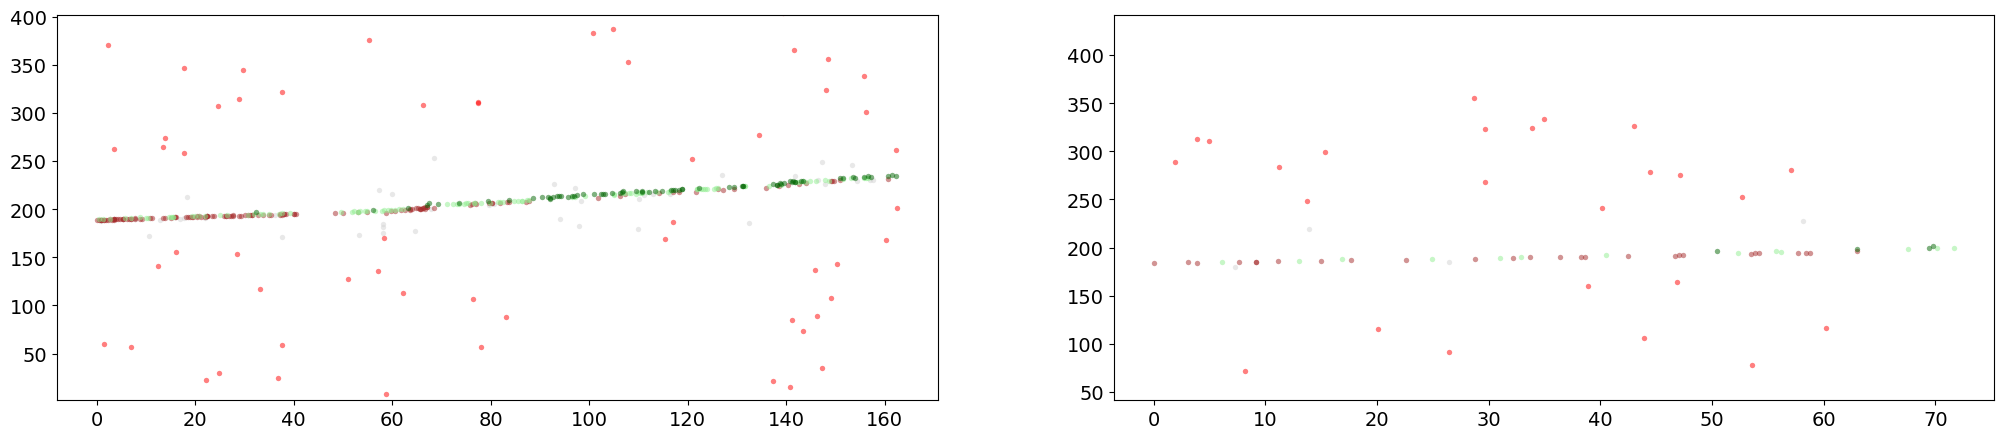

In [111]:
fig, axes = plt.subplots(1, len(atl03_uav_05.pair.unique()), figsize=(25, 5))

for b, beam in enumerate(atl03_uav_05.pair.unique()):

    gdf = atl03_uav_05[atl03_uav_05.pair == beam]
    
    dist = get_dist_vector(gdf, 0, gdf.shape[0])
    elev = numpy.asarray(gdf['height'])
    LIM_VAL_MAX, LIM_VAL_MIN = 200, 200
    YLAB = 'Elev [m]'
    phcl = numpy.asarray(gdf['atl08_class'])

    for i in range( len(class_name_list) ):
        idx = (phcl == i)

        if numpy.count_nonzero(idx) > 0:
            axes[b].scatter(dist[idx], elev[idx], s=15, alpha=0.5, linewidth=0,
                       c=class_color_list[i], label=class_name_list[i])
            if LIM_VAL_MAX is not None:
                 axes[b].set_ylim([numpy.median(elev[idx])-LIM_VAL_MIN, numpy.median(elev[idx])+LIM_VAL_MAX])

<Axes: >

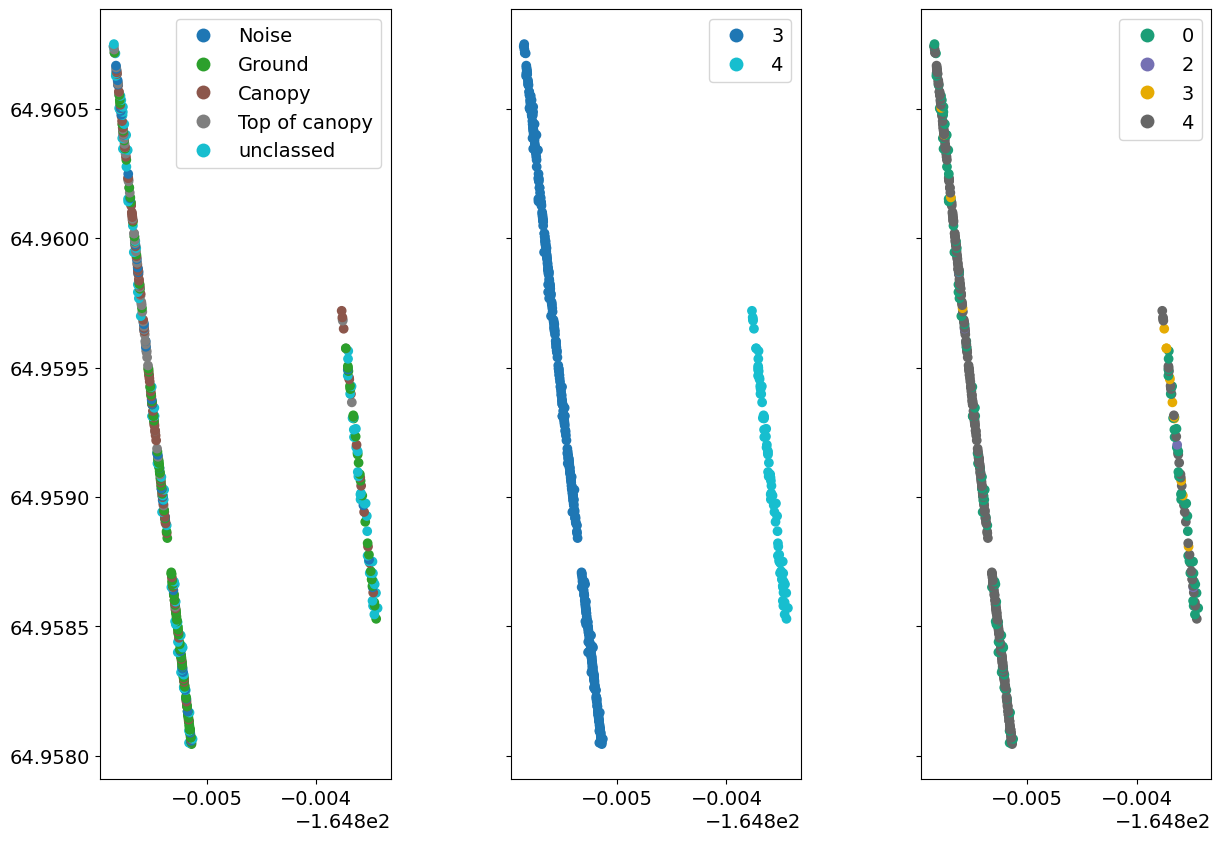

In [112]:
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10), sharey=True)
#atl03_uav_05.explore(column='height', vmin=200,vmax=250)
atl03_uav_05.plot(ax=ax, column='class_name', categorical=True, legend=True)
atl03_uav_05.plot(ax=ax2, column='spot', legend=True, categorical=True)
atl03_uav_05.plot(ax=ax3, column='atl03_cnf', legend=True, categorical=True, cmap='Dark2')